# Part 3 : Business Model

The Goal of All Investment Portfolios is to produce the highest risk/return ratio
Therefore my model will take a selection of loans and return the optimal loan portfolio for a desired return
The two inputs my model takes are amt of money to be invested and desired return

In [2]:
cd ../

/Users/fbales138/Git/loan_analysis


In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
import sklearn
import re
from textwrap import wrap
import random
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.dummy import DummyClassifier

np.random.seed(1)
sns.set_style('white')

In [3]:
loan_data = pd.read_csv('data/loan.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data Processing and Filtering

In [4]:
loan_data['term']=loan_data['term'].str.strip()

In [5]:
completed_loan_status_list = ['Fully Paid','Charged Off','Does not meet the credit policy. Status:Fully Paid','Does not meet the credit policy. Status:Charged Off','Default']
fully_paid_list = ['Fully Paid','Does not meet the credit policy. Status:Fully Paid']

Remove columns with all null values

In [6]:
loan_data=loan_data.dropna(axis=1,how='all')

Checking Feature Variance and removing those feautures with no variance

In [7]:
loan_feature_entry_count = loan_data.nunique()

In [8]:
loan_data=loan_data.drop(columns=loan_feature_entry_count.loc[loan_feature_entry_count==1].index.tolist())

Filtering out loans that are not completed

In [9]:
loan_data = loan_data.loc[loan_data['loan_status'].isin(completed_loan_status_list)]

Checking Out Categorical Features

In [10]:
categorical_cols = loan_data.select_dtypes('object').columns
categorical_cols

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'desc', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'next_pymnt_d', 'last_credit_pull_d', 'application_type',
       'verification_status_joint', 'sec_app_earliest_cr_line',
       'hardship_flag', 'hardship_reason', 'hardship_status',
       'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
       'hardship_loan_status', 'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date'],
      dtype='object')

- I have decided to not include certain categorical variables like 'emp_title' that
have high variance due to their more free form nature.

- For date categories, I am converting the dates to months prior to the loan date of issue.  I think this
will make their predictive capability higher since they are relative to the loan issuance, when conceivably a
model like this would be run
- Note: last_credit_pull_d is kept out because it appears LC has been very good at continuously pulling this data and it

In [46]:
model_categorical_features = [
                                'term', 'grade', 'sub_grade','emp_length',
                                'home_ownership', 'verification_status', 'pymnt_plan',
                                  'purpose', 'zip_code', 'addr_state','initial_list_status',
                                 'application_type', 'verification_status_joint','hardship_flag', 'hardship_reason',
                                 'hardship_status','hardship_loan_status','disbursement_method',
                                 'debt_settlement_flag','settlement_status',  
                             ]

In [12]:
date_features = ['next_pymnt_d','hardship_start_date', 'earliest_cr_line','sec_app_earliest_cr_line'
                        ,'hardship_end_date','payment_plan_start_date','debt_settlement_flag_date',
                       'settlement_date','issue_d']
for date_col in date_features:
    loan_data[date_col] = pd.to_datetime(loan_data[date_col],format='%b-%Y')

I reviewed the available numerica features and down selected to the ones I think are applicable

In [13]:
model_numerical_features= [
    'annual_inc','annual_inc_joint','dti',
'emp_length','inq_fi','inq_last_12m','inq_last_6mths','open_acc','open_acc_6m','open_il_12m',
'open_il_24m','open_act_il','open_rv_12m','open_rv_24m','pub_rec','pub_rec_bankruptcies','revol_util',
'tax_liens','tot_coll_amt','tot_cur_bal','tot_hi_cred_lim','total_acc','total_bal_ex_mort','total_bal_il',
'total_bc_limit','total_cu_tl','total_il_high_credit_limit','total_rev_hi_lim','int_rate','loan_amnt',
'installment','revol_bal','acc_now_delinq','acc_open_past_24mths','all_util','avg_cur_bal','bc_open_to_buy',
'bc_util','chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs','delinq_amnt','il_util',
'max_bal_bc','mo_sin_old_il_acct','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc',
'mths_since_last_delinq','mths_since_last_major_derog','mths_since_last_record','mths_since_rcnt_il',
'mths_since_recent_bc','mths_since_recent_bc_dlq','mths_since_recent_inq','mths_since_recent_revol_delinq',
'num_accts_ever_120_pd','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl',
'num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m','num_tl_30dpd',
'num_tl_90g_dpd_24m','num_tl_op_past_12m','pct_tl_nvr_dlq','percent_bc_gt_75','sec_app_earliest_cr_line',
'sec_app_inq_last_6mths','sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util','sec_app_open_act_il',
'sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med',
'sec_app_mths_since_last_major_derog','dti_joint','verification_status_joint','revol_bal_joint',
'next_pymnt_d','hardship_start_date', 'earliest_cr_line','sec_app_earliest_cr_line'
,'hardship_end_date','payment_plan_start_date','debt_settlement_flag_date','settlement_date'
]

In [14]:
target = ['loan_status']

In [15]:
categories_w_nulls=loan_data.columns[loan_data.isna().any()].tolist()

For the features with null values, I am bucketing them based on what I have determined is the most logical replacement technique
is most appropriate to impute. I have three buckets:
    - Min - NULL values to be replaced with population min
    - Max - NULL values to be replaced with population max
    - Mean - NULL values to be replaced with population mean
    - Blank - NULL values to be replaced with empty string

In [16]:
#### Variables Where NULL values replaced with the min:
min_variables=['num_tl_120dpd_2m','num_rev_accts','num_accts_ever_120_pd',
                'num_actv_rev_tl','num_actv_bc_tl','tot_coll_amt','num_bc_tl','num_il_tl','num_op_rev_tl',
                'num_rev_tl_bal_gt_0','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','num_bc_sats','num_sats','mort_acc',
                'total_bc_limit','acc_open_past_24mths','pub_rec_bankruptcies','collections_12_mths_ex_med','chargeoff_within_12_mths',
                'tax_liens','delinq_2yrs','delinq_amnt','total_acc','pub_rec','open_acc','inq_last_6mths','acc_now_delinq','open_act_il'
                ,'open_rv_24m','inq_fi','open_acc_6m','total_cu_tl','open_il_24m','open_il_12m','inq_last_12m','open_rv_12m'
                ,'max_bal_bc','mths_since_last_delinq','sec_app_inq_last_6mths','sec_app_mort_acc','sec_app_open_acc','sec_app_revol_util'
               ,'sec_app_open_act_il','sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med'
              ]

max_variables=['mths_since_last_major_derog','mths_since_recent_bc_dlq','mths_since_last_record','pct_tl_nvr_dlq'
               ,'mo_sin_old_il_acct','mths_since_recent_inq','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op'
               ,'mo_sin_rcnt_tl','mths_since_recent_bc','mths_since_recent_revol_delinq','mths_since_rcnt_il'
              ,'earliest_cr_line','next_pymnt_d','sec_app_earliest_cr_line','hardship_start_date','hardship_end_date'
              ,'payment_plan_start_date','debt_settlement_flag_date','settlement_date','sec_app_mths_since_last_major_derog'
              ]

mean_variables=['all_util','il_util','avg_cur_bal','total_rev_hi_lim','total_il_high_credit_limit','tot_hi_cred_lim',
                'tot_cur_bal','bc_util','percent_bc_gt_75','bc_open_to_buy','total_bal_ex_mort','revol_util','dti'
                ,'annual_inc','total_il_high_credit_limit','total_bal_il','annual_inc_joint','dti_joint','revol_bal_joint'
               ]
blank_variables=['zip_code','verification_status_joint','hardship_reason','hardship_status','hardship_loan_status'
                 ,'settlement_status']


In [17]:
for col in min_variables:
    loan_data[col] = loan_data[col].fillna(loan_data[col].min())
for col in max_variables:
    loan_data[col] = loan_data[col].fillna(loan_data[col].max())
for col in mean_variables:
    loan_data[col] = loan_data[col].fillna(loan_data[col].mean())
for col in blank_variables:
    loan_data[col] = loan_data[col].fillna('')

loan_data['emp_length']=loan_data['emp_length'].fillna('10+ years')
loan_data['emp_length']=loan_data['emp_length'].str.replace('< 1 year','0')
loan_data['emp_length'] = loan_data['emp_length'].apply(lambda x: int(re.findall(r'\d+',x)[0]))

In [24]:
#loan_data.to_csv('data/processed_loan_data.csv')
loan_data = pd.read_csv('data/processed_loan_data.csv')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (17,52,120,121,127,134) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
loan_data = loan_data[list(set(model_categorical_features+model_numerical_features+date_features+target))]

In [30]:
date_features = ['next_pymnt_d','hardship_start_date', 'earliest_cr_line','sec_app_earliest_cr_line'
                        ,'hardship_end_date','payment_plan_start_date','debt_settlement_flag_date',
                       'settlement_date','issue_d']
for date_col in date_features:
    loan_data[date_col] = pd.to_datetime(loan_data[date_col])

Since the loans in the dataset occured over a wide range of years, I am going to normalize all of the date
variables by making them relative to the loan date of issue.  I think this will make them much more valuable
to the model.  Their new format will be in months difference

Also, since I am assuming that we invest in the loans at the date of origination, I am removing the 'issue_d' feature from
the variables because it will not help with determining loan outcome at present date

In [37]:
relative_date_cols = [col for col in date_features if col != 'feature_d']
for date_col in relative_date_cols:
    new_header = date_col+"_diff_mo"
    loan_data[new_header] = (loan_data['issue_d'] - loan_data[date_col]).dt.days/30
    loan_data[new_header]=loan_data[new_header].astype(int)

loan_data=loan_data.drop(columns=date_features)

next_pymnt_d
hardship_start_date
earliest_cr_line
sec_app_earliest_cr_line
hardship_end_date
payment_plan_start_date
debt_settlement_flag_date
settlement_date
issue_d


In [40]:
#loan_data.to_csv('data/processed_loan_data.csv')

Create Dummy Variables

In [47]:
dummies = pd.get_dummies(loan_data[model_categorical_features],drop_first=True)
model_input=loan_data.drop(model_categorical_features,axis=1)
model_input = pd.concat([model_input,dummies],axis=1)

In [49]:
model_input['loan_status'] = np.where(model_input['loan_status'].isin(fully_paid_list),'True','False')

In [160]:
model_input['loan_status'].value_counts()

True     1002213
False     252897
Name: loan_status, dtype: int64

The data is not very well balanced, with defaulted loans only representing about a fifth of all loans.
I will utilize the built-in class balancer in the model to help adjust for this

In [51]:
#model_input.to_csv('data/model_input.csv')

SystemError: <built-in method item of numpy.ndarray object at 0x1a25d29f80> returned a result with an error set

In [4]:
#model_input = pd.read_csv('data/model_input.csv')

In [5]:
#model_input=model_input.drop(columns=['Unnamed: 0'])

In [6]:
y = np.array(model_input['loan_status'])
X = model_input.drop(['loan_status'],axis=1)

### Random Forest Model

- I have decided to go solely with a random forest model in the interest of time.
I do not need to scale the data which would take a lot of time, and I do not have to 
worry as much about collinearity among features

- Furthermore I find decision trees and random forests very business friendly because of their
ease of interpretibility. Even though I cannot really see the tree logic with a random forest,
I can see quantitatively which features are important to deciding loan outcome, which helps 
me better understand what the key drivers are

- I have chosed to go with classification over regression.  My intuition is that it will likely
be more accurate at prediction and require less time.  Having said this, it would be interesting to
see what a random forest regression with net annualized return as the target would produce

##### Dimensionality Reduction

I do not think dimensionality reduction is terribly necessary given I will run feature importance threshold analysis
later and this takes a lot of time to run

In [57]:
features = preprocessing.StandardScaler().fit_transform(X)
pca = PCA(n_components=0.99,whiten=True)
features_pca = pca.fit_transform(features)
print("Original Feature Count: {feature_count}".format(feature_count=features.shape[1]))
print("Reduced Feature Count: {pca_feature_count}".format(pca_feature_count=features_pca.shape[1]))

Original Feature Count: 1171


KeyError: 'pca_feature_count'

In [13]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

In [14]:
loan_forest = RandomForestClassifier(class_weight='balanced',n_jobs=-1)
loan_model=loan_forest.fit(X_train,y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [15]:
loan_forest_y_predictions = loan_forest.predict(X_test)

In [16]:
loan_forest_y_predictions[:4]

array([ True,  True,  True,  True])

#### Model Performance

In [161]:
print('-------confusion_matrix-------')
print(confusion_matrix(y_test,loan_forest_y_predictions))
print('-------classification_report-------')
print(classification_report(y_test,loan_forest_y_predictions))
print('-------accuracy_score-------')
print(accuracy_score(y_test, loan_forest_y_predictions))

-------confusion_matrix-------
[[ 19413  56538]
 [ 15337 285245]]
-------classification_report-------
              precision    recall  f1-score   support

       False       0.56      0.26      0.35     75951
        True       0.83      0.95      0.89    300582

    accuracy                           0.81    376533
   macro avg       0.70      0.60      0.62    376533
weighted avg       0.78      0.81      0.78    376533

-------accuracy_score-------
0.8091136766232973


This model does a decent job.  However it has a very high type 1 error.  
This could be due to the fact that the imbalance in the data.
What I would want to see if anything is a model that is overly cautious 
and has many more false negatives than false positives as is the case here
since false positives are much worse for financial performance

##### Feature Selection

Text(0.5, 0, 'Relative Importance')

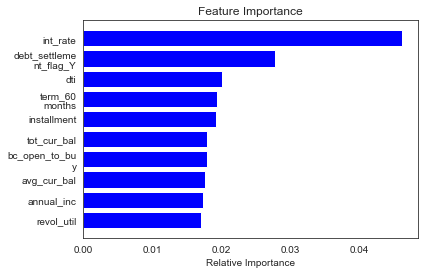

In [22]:
importances = loan_forest.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]
top_indices = indices[0:10][::-1]
plt.figure(1)
plt.title('Feature Importance')
plt.barh(range(len(top_indices)), importances[top_indices], color = 'b', align = 'center')
labels = features[top_indices]
labels = [ '\n'.join(wrap(l,13)) for l in labels ]
plt.yticks(range(len(top_indices)), labels)
plt.xlabel('Relative Importance')

Text(0, 0.5, 'Weekly')

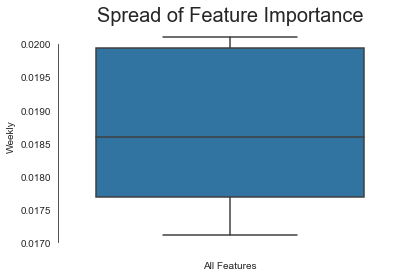

In [23]:
ax = sns.boxplot(y=importances[top_indices],showfliers=False)
sns.despine(offset=5, trim=True);
ax.set_title('Spread of Feature Importance',size=20)
ax.set_xlabel('All Features',size=10)
ax.set_ylabel(f'Weekly',size=10)

In order to simplify the model I am going to remove all features with an importance that is less than 0.1
and see how that affects model accuracy

In [41]:
sfm = SelectFromModel(loan_forest, threshold=0.01)
sfm.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True,
                                                 class_weight='balanced',
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=10, n_jobs=-1,
                                                 oob_score=False,
                                                 random_state=None, verbose=0,

In [42]:
for feature_list_index in sfm.get_support(indices=True):
    print(X.columns[feature_list_index])

revol_bal
mths_since_recent_inq
total_bc_limit
num_actv_rev_tl
num_bc_tl
total_il_high_credit_limit
mo_sin_old_il_acct
total_rev_hi_lim
revol_util
total_bal_ex_mort
num_op_rev_tl
mo_sin_rcnt_rev_tl_op
avg_cur_bal
total_acc
tot_hi_cred_lim
bc_open_to_buy
open_acc
num_sats
percent_bc_gt_75
bc_util
num_il_tl
installment
loan_amnt
annual_inc
num_rev_accts
mo_sin_rcnt_tl
mths_since_recent_bc
tot_cur_bal
int_rate
dti
mo_sin_old_rev_tl_op
acc_open_past_24mths
next_pymnt_d_diff_mo
hardship_start_date_diff_mo
earliest_cr_line_diff_mo
sec_app_earliest_cr_line_diff_mo
hardship_end_date_diff_mo
payment_plan_start_date_diff_mo
debt_settlement_flag_date_diff_mo
settlement_date_diff_mo
term_60 months
debt_settlement_flag_Y
settlement_status_COMPLETE


In [43]:
X_imp_feature_train = sfm.transform(X_train)
X_imp_feature_test = sfm.transform(X_test)

In [44]:
loan_forest_imp_features = RandomForestClassifier(class_weight='balanced',n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
loan_forest_imp_features.fit(X_imp_feature_train, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [45]:
y_pred = loan_forest_imp_features.predict(X_imp_feature_test)

In [183]:

print('-------confusion_matrix-------')
print(confusion_matrix(y_test, y_pred))
print('-------classification_report-------')
print(classification_report(y_test, y_pred))
print('-------accuracy_score-------')
print(sklearn.metrics.accuracy_score(y_test, y_pred))

-------confusion_matrix-------
[[ 19307  56644]
 [ 15401 285181]]
-------classification_report-------
              precision    recall  f1-score   support

       False       0.56      0.25      0.35     75951
        True       0.83      0.95      0.89    300582

    accuracy                           0.81    376533
   macro avg       0.70      0.60      0.62    376533
weighted avg       0.78      0.81      0.78    376533

-------accuracy_score-------
0.8086621889714846


In [188]:
report = classification_report(y_test, y_pred,output_dict=True)
df = pd.DataFrame(report).T
df.to_csv('data/classification_report.csv')

Now that I have reduced the feautre set I can utilize RandomSearchCV to tune the hypeparameters

NOTE: RandomSearchCV was taking too long to run and so in the interest of time I skipped it

In [174]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [175]:
loan_forest_random = RandomizedSearchCV(estimator = loan_forest_imp_features, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=0, 
                               random_state= 1, 
                               n_jobs = -1)
# Fit the random search model.
loan_forest_random.fit(X_imp_feature_train, y_train)

KeyboardInterrupt: 

I like to inspect some of the model's worse performing predictions to see if there is some outlier
or other reason that might be causing my model to be incorrectly predicting loan outcomes

In [47]:
y_prob = loan_forest_imp_features.predict_proba(X_imp_feature_test)

In [49]:
check_df = X_test.copy()

In [55]:
check_df['pred_default_prob'] = y_prob[:,1]
check_df['loan_status'] = y_test
check_df['model_error_mag'] = abs(check_df['pred_payment_prob']-check_df['loan_status'])
check_df.sort_values(by='model_error_mag',ascending=False)[:10]

,revol_bal,mths_since_recent_inq,num_bc_sats,sec_app_num_rev_accts,num_tl_30dpd,open_il_12m,total_bc_limit,num_actv_rev_tl,num_bc_tl,num_rev_tl_bal_gt_0,...,hardship_loan_status_Issued,hardship_loan_status_Late (16-30 days),hardship_loan_status_Late (31-120 days),disbursement_method_DirectPay,debt_settlement_flag_Y,settlement_status_BROKEN,settlement_status_COMPLETE,pred_default_prob,loan_status,model_error_mag
926618,10050,25.0,3.0,0.0,0.0,0.0,29900.0,3.0,8.0,3.0,...,0,0,0,0,0,0,0,1.0,False,1.0
881379,12071,5.0,6.0,0.0,1.0,0.0,18400.0,6.0,14.0,6.0,...,0,0,0,0,0,0,0,1.0,False,1.0
88833,8415,16.0,4.0,0.0,0.0,1.0,7500.0,7.0,4.0,7.0,...,0,0,0,0,0,0,0,1.0,False,1.0
1163061,21720,17.0,4.0,0.0,0.0,0.0,31900.0,5.0,5.0,5.0,...,0,0,0,0,0,0,0,1.0,False,1.0
611567,19271,1.0,7.0,0.0,0.0,0.0,23700.0,12.0,19.0,12.0,...,0,0,0,0,0,0,0,1.0,False,1.0
239712,2348,4.0,2.0,0.0,0.0,0.0,3400.0,3.0,3.0,3.0,...,0,0,0,0,0,0,0,1.0,False,1.0
941600,39884,10.0,11.0,0.0,0.0,0.0,36500.0,14.0,23.0,14.0,...,0,0,0,0,0,0,0,1.0,False,1.0
829657,6325,0.0,1.0,0.0,0.0,0.0,800.0,3.0,6.0,3.0,...,0,0,0,0,0,0,0,1.0,False,1.0
920793,12117,5.0,3.0,0.0,0.0,0.0,15900.0,3.0,7.0,3.0,...,0,0,0,0,0,0,0,1.0,False,1.0
185439,23303,7.0,5.0,0.0,0.0,0.0,41200.0,5.0,14.0,5.0,...,0,0,0,0,0,0,0,1.0,False,1.0


#### Baseline Comparison Test

One quick dummy baseline validation method.  The final model has 13% higher accuracy
than the dummy model

In [178]:
dummy = DummyClassifier()
dummy.fit(X_imp_feature_train, y_train)
dummy.score(X_imp_feature_test, y_test)

0.6791516281441468

In [ ]:
print(classification_report(y_test, y_pred))


As a simple test of my model, I am going to bucket the interest rates by bins of 5.  I then create a variable called 'risk normalized return' which is the interest rate of the loan multiplied by the probabilty of full payment.  I have a function that will take a dictionary of interest rate buckets and how many bonds in that bucket are desired.  The function returns the index of the bonds, (and for the sake of checking, the outcome of the loan and the calculated risk normalized return).  I will check this against another function I created that just chooses bonds at random from within the buckets, to see if my model does in fact lead to lower default rates.

In [97]:
int_rate_buckets=[5,10,15,20,25,30,35]
int_rate_labels=['5-10','10-15','15-20','20-25','25-30','30-35']

In [124]:
available_loans = X_test.copy()
available_loans['loan_paid'] =y_test
available_loans['pred_payment_prob'] = y_prob[:,1] 
available_loans['risk_norm_return'] = available_loans['int_rate']*available_loans['pred_payment_prob']
available_loans['int_rate_buckets'] = pd.cut(available_loans['int_rate'],bins=int_rate_buckets,labels=int_rate_labels)
available_loans.groupby('int_rate_buckets').risk_norm_return.count()

int_rate_buckets
5-10     103598
10-15    155355
15-20     87438
20-25     22940
25-30      5973
30-35      1229
Name: risk_norm_return, dtype: int64

In [126]:
available_loans.head()

,revol_bal,mths_since_recent_inq,num_bc_sats,sec_app_num_rev_accts,num_tl_30dpd,open_il_12m,total_bc_limit,num_actv_rev_tl,num_bc_tl,num_rev_tl_bal_gt_0,...,hardship_loan_status_Late (16-30 days),hardship_loan_status_Late (31-120 days),disbursement_method_DirectPay,debt_settlement_flag_Y,settlement_status_BROKEN,settlement_status_COMPLETE,loan_paid,pred_payment_prob,risk_norm_return,int_rate_buckets
996250,3095,25.0,0.0,0.0,0.0,0.0,32000.0,0.0,0.0,0.0,...,0,0,0,0,0,0,True,1.0,6.030,5-10
975644,26705,7.0,2.0,0.0,0.0,0.0,3500.0,4.0,9.0,4.0,...,0,0,0,0,0,0,True,0.9,10.908,10-15
404170,5936,1.0,13.0,0.0,0.0,0.0,83100.0,7.0,20.0,7.0,...,0,0,0,0,0,0,True,0.9,8.253,5-10
264648,16154,17.0,6.0,0.0,0.0,0.0,29700.0,7.0,13.0,7.0,...,0,0,0,0,0,0,True,1.0,5.320,5-10
918829,26026,17.0,5.0,0.0,0.0,0.0,31600.0,6.0,14.0,6.0,...,0,0,0,0,0,0,True,0.7,7.112,10-15


In [127]:
available_loans.index.name='bond_id'
available_loans=available_loans.groupby('int_rate_buckets').apply(lambda x: x.sort_values(by='risk_norm_return',ascending=False))

In [129]:
def model_bond_selection(loan_selection_dict):
    """This Function will take a dataset of loans with a desired amount of money to invest
    and interest rate, and return the best risk-adjusted return.
    :var loan_selection_dict: type dict -  dictionary of desired number of bonds to purchase per given int rate bucket.
    
    return: type list - list of bond indexes
    """
    bond_id_list = []
    for interest_bucket,loan_count in loan_selection_dict.items():
        best_bonds=available_loans.loc[interest_bucket][:loan_count].index.tolist()
        bond_id_list=bond_id_list+best_bonds
    return best_bonds

def baseline_bond_selection(loan_selection_dict):
    """This Function will take a dataset of loans with a desired amount of money to invest
    and interest rate, and return the a random selection from those buckets.
    :var loan_selection_dict: type dict -  dictionary of desired number of bonds to purchase per given int rate bucket.
    
    return: type list - list of bond indexes
    """
    bond_id_list = []
    for interest_bucket,loan_count in loan_selection_dict.items():
        available_bonds=available_loans.loc[interest_bucket].index.tolist()
        list_indexes = random.sample(range(len(available_bonds)), loan_count)
        chosen_bonds = [available_bonds[ix] for ix in list_indexes]
    return chosen_bonds

TEST

for this test, I run 100 iterations where I randomly select numbers of loans to purchase in every interest bucket.
the model returns what it believes are the highest rated loans in the interest bracket, and the baseline randomly chooses.
After aggregating the results and displaying them below, it appears the Random Forest model is effective at predicting
loan outcomes above the baseline.

In [173]:
model_loan_selection_dict={}
baseline_loan_selection_dict={}
for i in range(100):
    loan_no_desired = random.sample(range(10,100), len(int_rate_labels))
    int_rate_labels=['5-10','10-15','15-20','20-25','25-30','30-35']
    int_rate_dict = dict(zip(int_rate_labels,loan_no_desired))
    model_loan_selection_dict[i] = model_bond_selection(int_rate_dict)
    baseline_loan_selection_dict[i] = baseline_bond_selection(int_rate_dict)

In [130]:
test_df = available_loans.reset_index(level=0,drop=True)

In [155]:
model_performance_list = []
base_performance_list = []

for key in model_loan_selection_dict:
    loan_no=len(model_loan_selection_dict[key])
    temp_df=test_df.loc[model_loan_selection_dict[key]]
    loans_fully_paid = temp_df['loan_paid'].sum()
    default_percent = 1-(loans_fully_paid/loan_no)
    model_performance_list.append([default_percent,loans_fully_paid,loan_no])
    model_performance_df=pd.DataFrame(model_performance_list,columns=['percent_defaults','loans_paid','loan_count'])
for key in baseline_loan_selection_dict:
    loan_no=len(baseline_loan_selection_dict[key])
    temp_df=test_df.loc[baseline_loan_selection_dict[key]]
    loans_fully_paid = temp_df['loan_paid'].sum()
    default_percent = 1-(loans_fully_paid/loan_no)
    base_performance_list.append([default_percent,loans_fully_paid,loan_no])
    base_performance_df=pd.DataFrame(base_performance_list,columns=['percent_defaults','loans_paid','loan_count'])


In [164]:
print('Model Portfolio Selection Mean Default Rate: ' ,round(base_performance_df.percent_defaults.mean()*100,2),'%')
print('Baseline Portfolio Selection Mean Default Rate: ' ,round(model_performance_df.percent_defaults.mean()*100,2),'%')


Model Portfolio Selection Mean Default Rate:  48.53 %
Baseline Portfolio Selection Mean Default Rate:  28.02 %


In [169]:
print('Model Portfolio Selection Total Default Rate: ' ,round((1-(model_performance_df.loans_paid.sum()/model_performance_df.loan_count.sum()))*100,2),'%')
print('Baseline Portfolio Selection Total Default Rate: ' ,round((1-(base_performance_df.loans_paid.sum()/base_performance_df.loan_count.sum()))*100,2),'%')


Model Portfolio Selection Total Default Rate:  29.82 %
Baseline Portfolio Selection Total Default Rate:  48.82 %


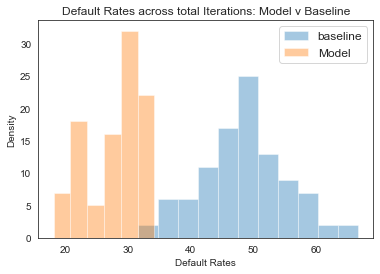

In [182]:
sns.distplot(base_performance_df['percent_defaults']*100,  kde=False, label='baseline')
sns.distplot(model_performance_df['percent_defaults']*100,  kde=False,label='Model')
plt.legend(prop={'size': 12})
plt.title('Default Rates across total Iterations: Model v Baseline')
plt.xlabel('Default Rates')
plt.ylabel('Density')
plt.savefig('data/model_v_distro.png')

In [181]:
plt.savefig('data/model_v_distro.png')

<Figure size 432x288 with 0 Axes>